In [2]:
import numpy as np
import networkx as nx
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import itertools 


**Higher-order Interactions**

Consider the following system of differential equations that describe the dynamics of oscillators with high-order interactions of up to order D: 

$$\dot{\theta_i} = \omega + \frac{\gamma_1}{\langle K^{(1)} \rangle } \sum_{j= 1}^N A_{ij} \sin(\theta_j - \theta_i) +  \frac{\gamma_2}{2!\langle K^{(2)} \rangle } \sum_{j, k= 1}^N B_{ijk} \sin(\theta_j + \theta_k - 2\theta_i) + \cdots  \frac{\gamma_D}{D!\langle K^{(D)} \rangle } \sum_{j_1 \cdots, j_D = 1}^N M_{ij_1, \cdots j_D} \sin \bigg (\sum _{m=1} ^D \theta_{j_m}  - D\theta_i \bigg) $$

We aim to integrate this system forward with respect to the example star-clique network from Lucas et al. (2020) where we have a star of size $N_s = 6$ and a clique of size $N_c = 7$. 

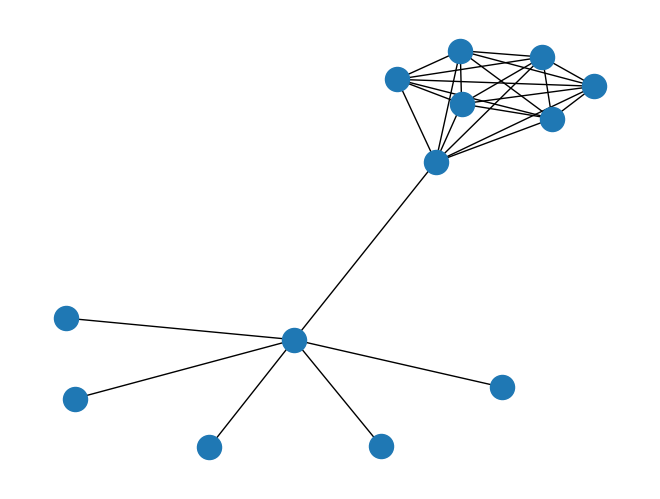

In [13]:
###########################
#### Define the network####
###########################

# Define the network
star_edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
star = nx.Graph(star_edges)
clique = nx.complete_graph(7)

# Create the final graph
star_clique = nx.disjoint_union(star, clique)
star_clique.add_edge(0, len(star))  # Add the edge joining star and clique

# Get the number of nodes in the final graph
N = star_clique.number_of_nodes()

nx.draw(star_clique)

In [14]:

# Define adjacency tensors for interactions up to D=6
max_order = 6
adj_tensors = [np.zeros((N,) * (d + 1)) for d in range(1, max_order + 1)]

# Fill the adjacency tensors based on star_clique structure
for d in range(1, max_order + 1):
    if d == 1:
        for edge in star_clique.edges():
            i, j = edge
            adj_tensors[d - 1][i, j] = adj_tensors[d - 1][j, i] = 1  # Pairwise interactions
    else:
        for subset in itertools.combinations(range(N), d + 1):
            indices = tuple(sorted(subset))
            adj_tensors[d - 1][indices] = 1

# Parameters
omega = 1.0
gamma = [1.0 for _ in range(max_order)]
K_avg = [np.mean(np.sum(adj_tensors[d], axis=tuple(range(1, d + 1)))) for d in range(max_order)]




# Differential equation
def dtheta_dt_multi_order(t, theta):
    dtheta = np.zeros(N)
    for i in range(N):
        interaction_sum = 0
        for d in range(1, max_order + 1):
            tensor = adj_tensors[d - 1]
            if d == 1:
                sum_d = np.sum(tensor[i, :] * np.sin(theta - theta[i]))
            else:
                sum_d = 0
                for idx in itertools.combinations(range(N), d):
                    idx_tuple = (i,) + idx
                    if tensor[idx_tuple] != 0:
                        phase_sum = np.sum(theta[list(idx)]) - d * theta[i]
                        sum_d += np.sin(phase_sum)
            interaction_sum += (gamma[d - 1] / (np.math.factorial(d) * K_avg[d - 1])) * sum_d
        dtheta[i] = omega + interaction_sum
    return dtheta



In [15]:

# Initial conditions
theta0 = np.random.uniform(0, 2 * np.pi, N)

# Time span
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Solve the system
sol_star_clique = solve_ivp(dtheta_dt_multi_order, t_span, theta0, t_eval=t_eval)

# Calculate sine of phases
sin_theta_star_clique = np.sin(sol_star_clique.y)



/var/folders/m3/1xd69xhj5gjbd6qm3wknw7wc0000gn/T/ipykernel_6933/2773022030.py:37: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  interaction_sum += (gamma[d - 1] / (np.math.factorial(d) * K_avg[d - 1])) * sum_d


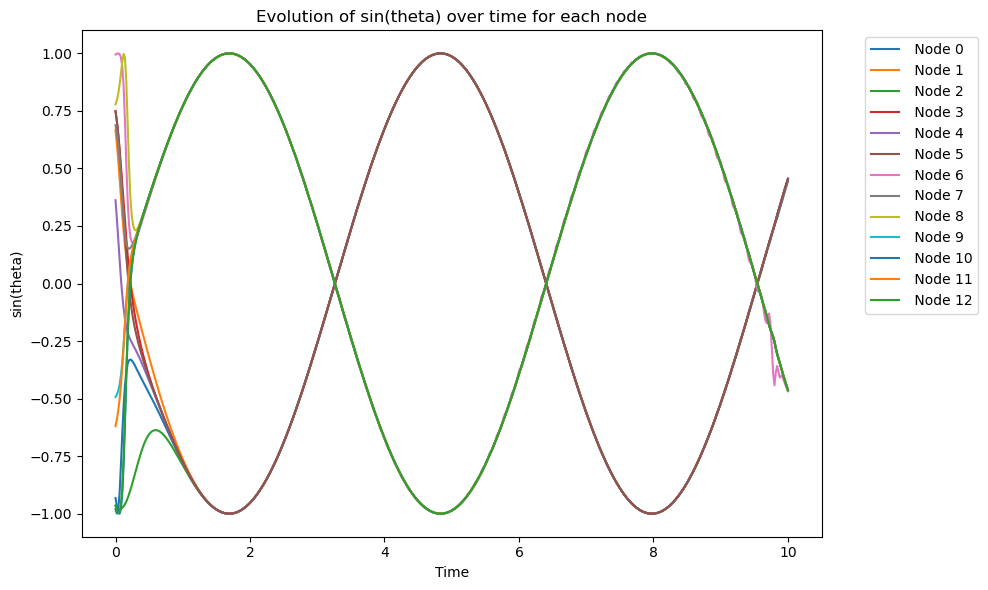

In [18]:
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(sol_star_clique.t, sin_theta_star_clique[i], label=f' Node {i}')
plt.xlabel('Time')
plt.ylabel('sin(theta)')
plt.title('Evolution of sin(theta) over time for each node')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


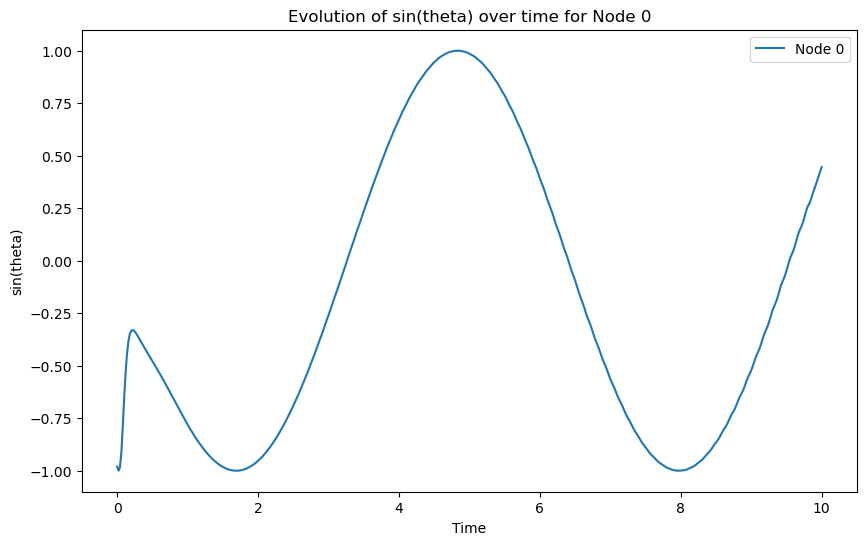

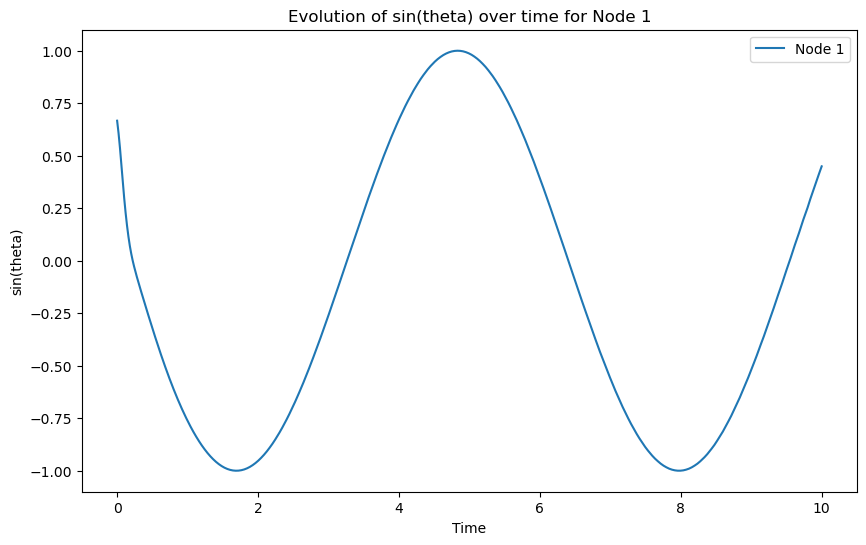

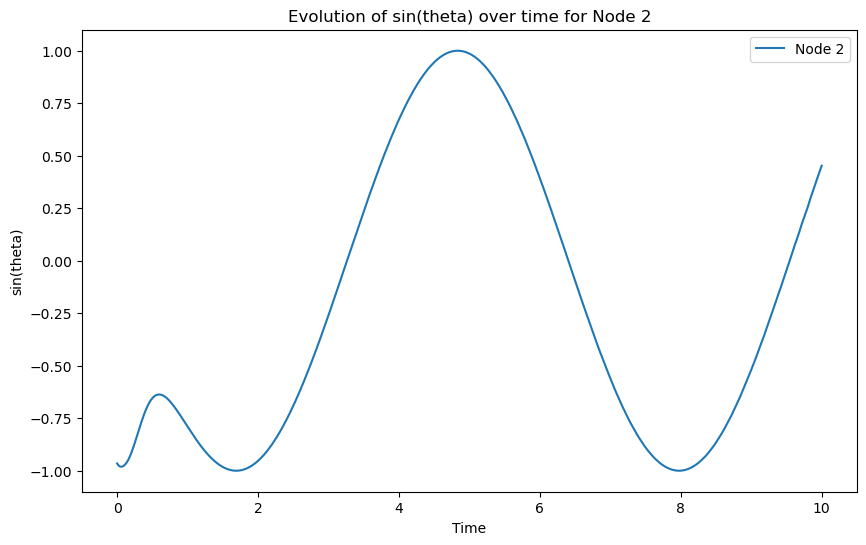

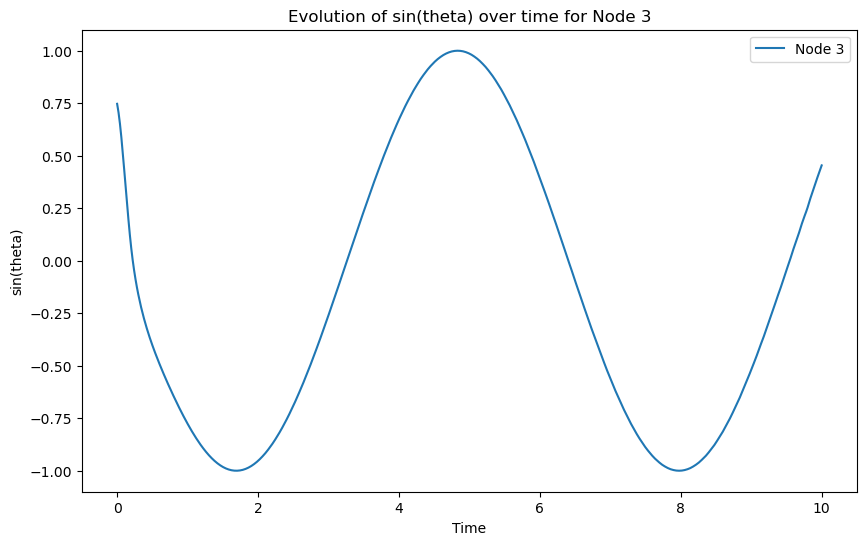

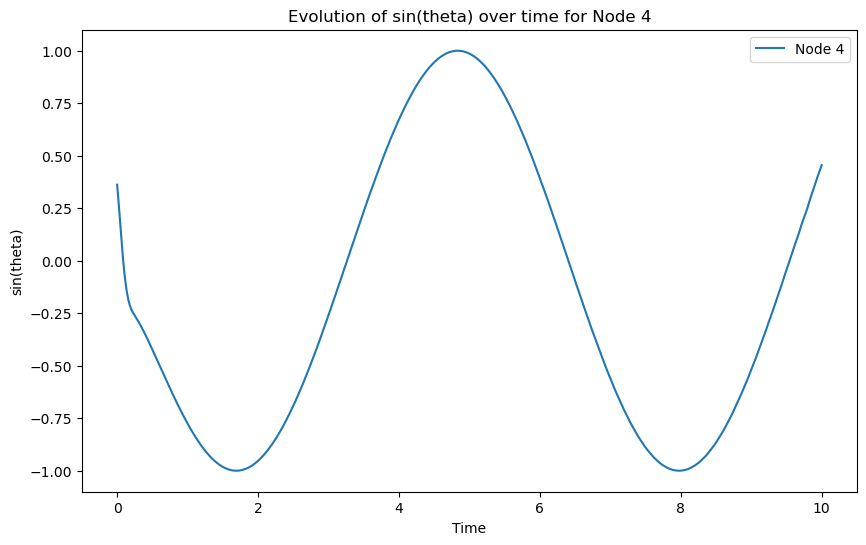

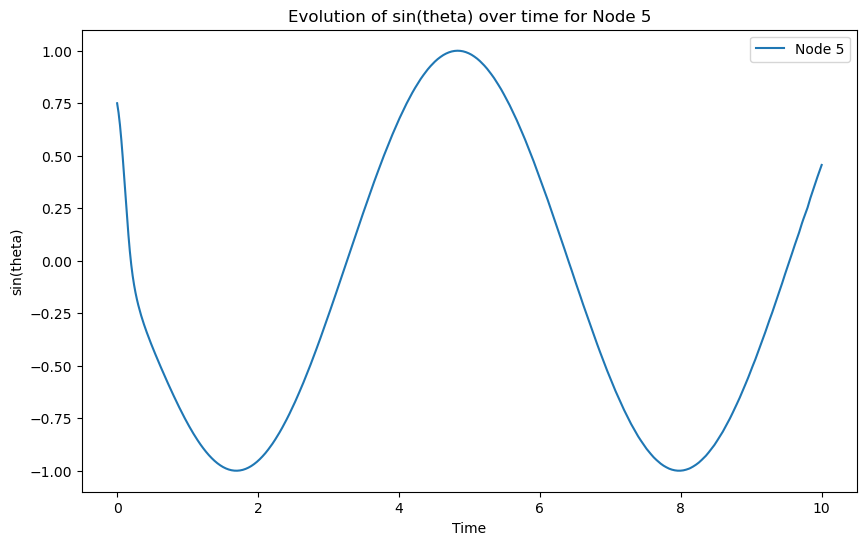

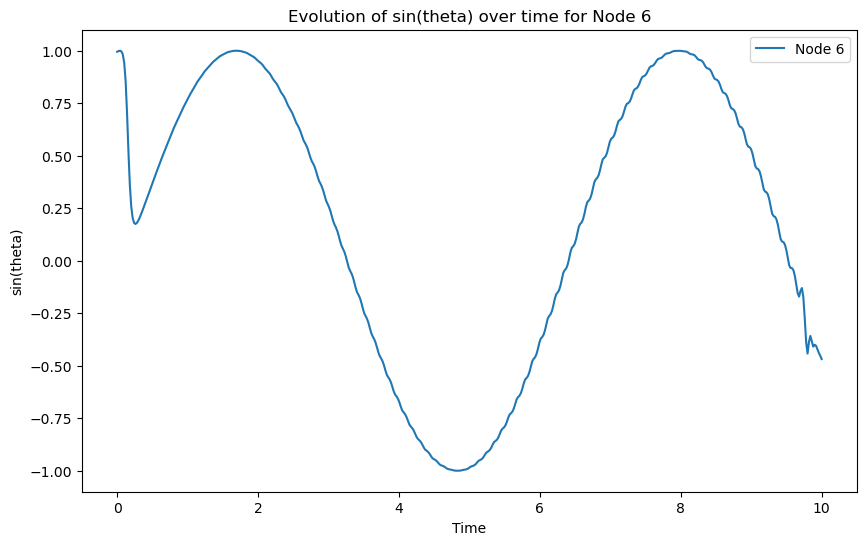

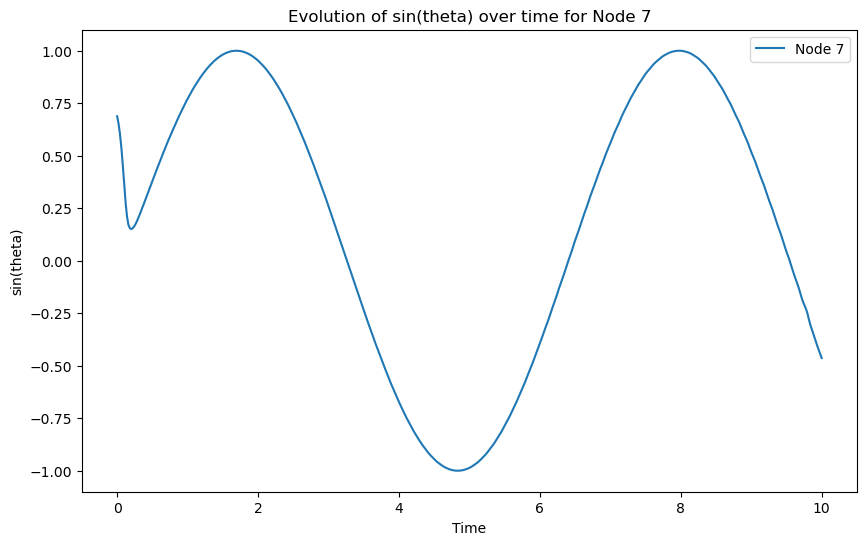

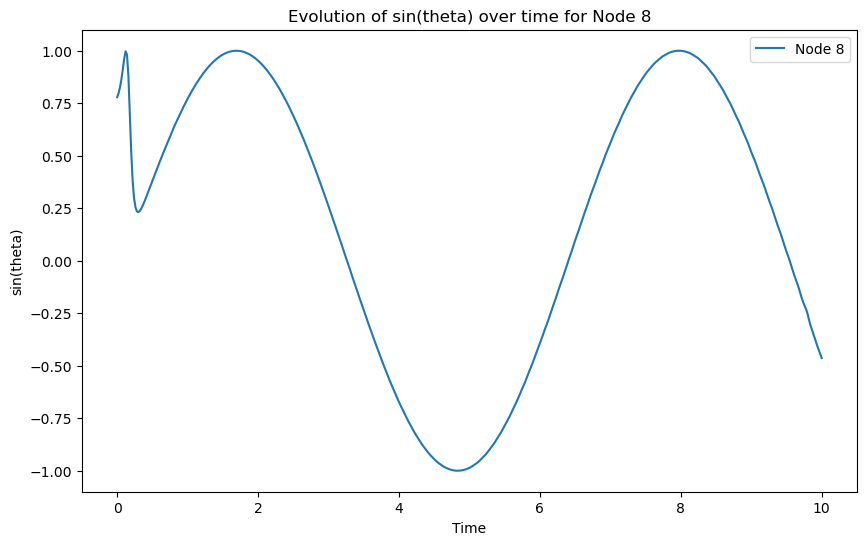

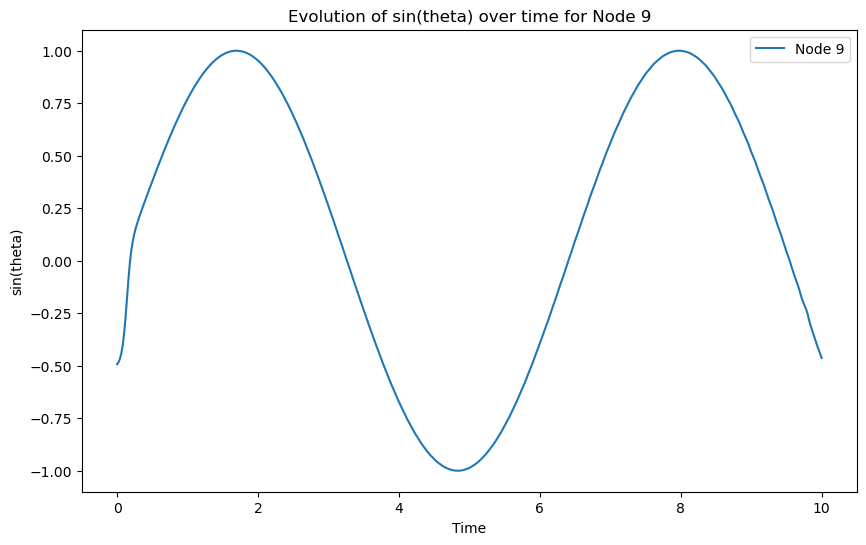

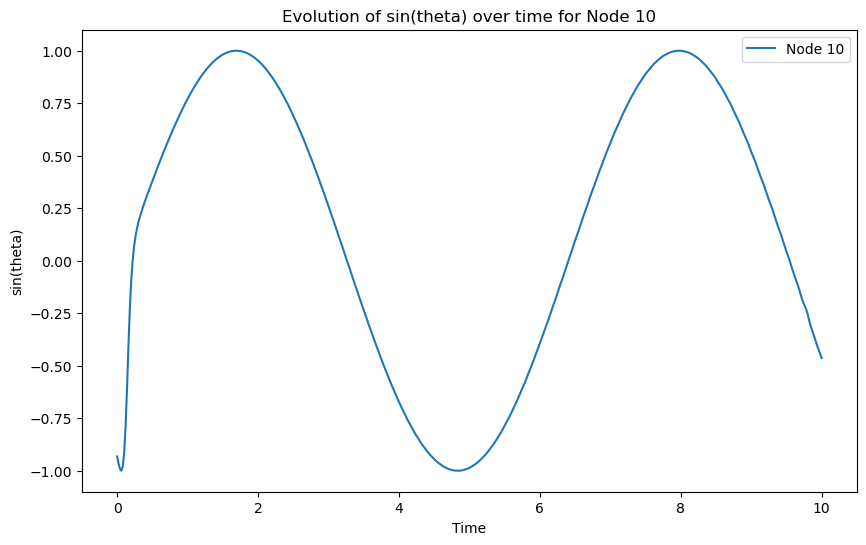

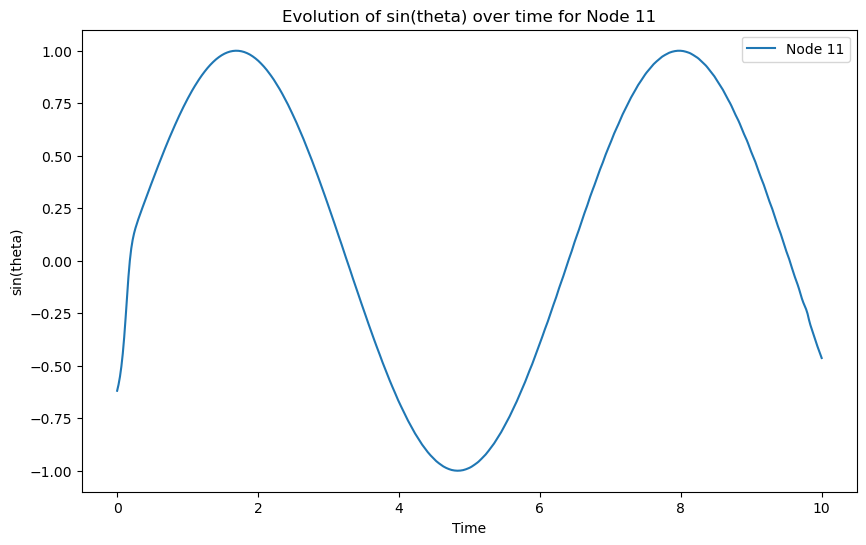

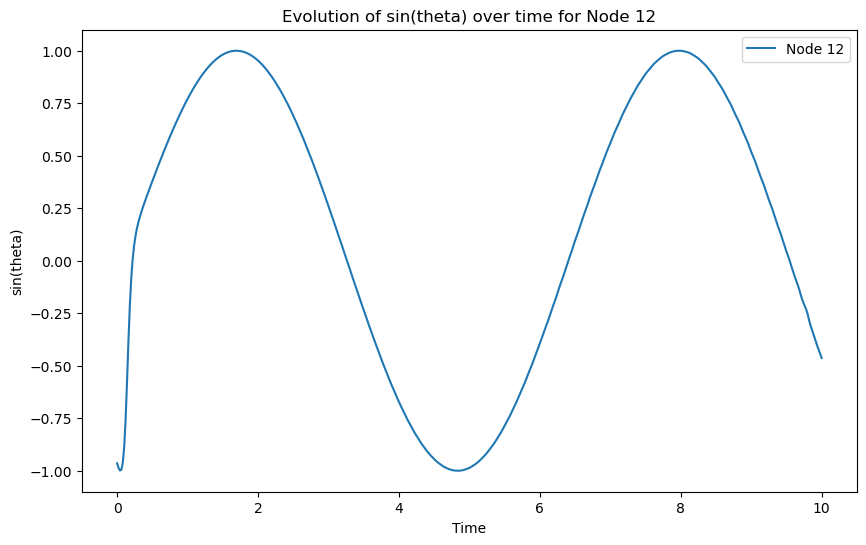

In [19]:
for i in range(N):
    plt.figure(figsize=(10, 6))
    plt.plot(sol_star_clique.t, sin_theta_star_clique[i], label=f'Node {i}')
    plt.xlabel('Time')
    plt.ylabel('sin(theta)')
    plt.title(f'Evolution of sin(theta) over time for Node {i}')
    plt.legend()
    plt.show()
    plt.pause(1)  # Pause for 1 second before showing the next plot

Looks like the nodes in each subgraph (star vs. clique) are synchronized, giving us two  synchronized clusters.

**Stability of star-clique model**

This section of the notebook focuses on evaluating the stability of the synchronized solution for that star-clique model. According to Lucas et. al., the stability of the synchronized solution is determined by the eigenvalues of the multiorder Laplacian $L^{\text{mul}}$ (eq. 8): 

$$L_{ij}^{\text{mul}} = \sum_{d=1}^D \frac{\gamma_d}{\langle K ^{(d)} \rangle} L_{ij}^{(d)}$$

where 


$$L_{ij}^{(d)} = dK_i^{(d)} \delta_{ij}- A_{ij}^{(d)}$$ 


with the Kronecker delta $\delta_{ij}$. The generalized Laplaician of order $d$ is defined by the degree $K_i^{(d)}$, i.e., the number of distinct $d$-simplices that node $i$ is part of, and the adjacency matric $A_{ij}^{(d)}$ i.e. the number of distic $d$-simplices that the par of nodes $(i, j)$ is a part of, 

$$K_i^{(d)} = \frac{1}{d!} \sum_{j_1, \cdots j_D = 1}^N M_{i, j_1, \cdots, j_D}, $$

$$A_{iJ}^{(d)}= \frac{1}{(d-1)!} \sum_{j_2, \cdots j_D = 1}^N M_{i, j, j_2\cdots, j_D}$$,



The multiorder Laplcian, $L_{ij}^{\text{mul}}$ can be thought of as a weighted sum of the Laplacian matrices of order $d$, i.e. weighted sum of $L_{ij}^{(d)}$. The $N$ Lyapunov exponents of the synchronized state is given by 

$$\lambda_{\alpha}^{(d)} = - \frac{\gamma_d}{\langle K^{(d)} \rangle } \Lambda_\alpha ^{(d)}$$

/var/folders/m3/1xd69xhj5gjbd6qm3wknw7wc0000gn/T/ipykernel_6933/3092675523.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return K_d / np.math.factorial(d)
/var/folders/m3/1xd69xhj5gjbd6qm3wknw7wc0000gn/T/ipykernel_6933/3092675523.py:19: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return A_d / np.math.factorial(d - 1)


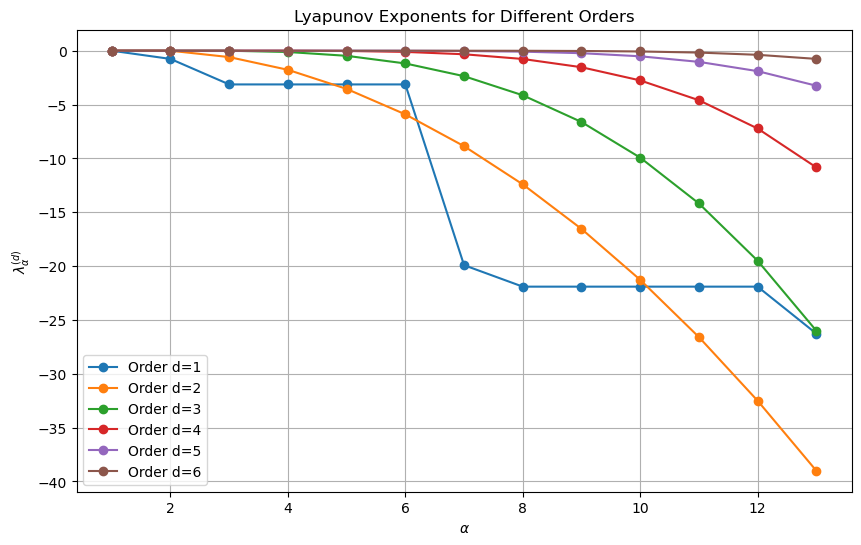

In [47]:

# Functions to compute K_i^(d) and A_ij^(d)
def compute_K_d(d):
    K_d = np.zeros(N)
    for i in range(N):
        if d == 1:
            K_d[i] = np.sum(adj_tensors[d - 1][i, :])
        else:
            K_d[i] = np.sum(adj_tensors[d - 1][i])
    return K_d / np.math.factorial(d)

def compute_A_d(d):
    A_d = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if d == 1:
                A_d[i, j] = adj_tensors[d - 1][i, j]
            else:
                A_d[i, j] = np.sum(adj_tensors[d - 1][i, j])
    return A_d / np.math.factorial(d - 1)


# Compute Lyapunov exponents for each Laplacian matrix L^(d) 
plt.figure(figsize=(10, 6))

for d in range(1, max_order + 1):
    K_d = compute_K_d(d)
    A_d = compute_A_d(d)
    L_d = np.diag(d * K_d) - A_d
    eigenvalues = np.linalg.eigvals(L_d)
    sorted_eigenvalues = np.sort(eigenvalues)
    lyapunov_exponents = - (gamma[d - 1] / K_avg[d - 1]) * sorted_eigenvalues
    
    plt.plot(range(1, N + 1), lyapunov_exponents, marker='o', label=f'Order d={d}')

plt.title('Lyapunov Exponents for Different Orders')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\lambda_{\alpha}^{(d)}$')
plt.legend()
plt.grid(True)
plt.show()

This doesn't look entirely like the plot in the paper, need to trouble shoot to see if I am understanding how to construct these matrices properly.